In [49]:
%matplotlib inline

import re
import sqlite3
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

con = sqlite3.connect('main.db')

### Raw Data

In [54]:
project_name = 'cpython'

sql = f'''
select tag, date(creator_dt)
from projects join releases on projects.id = releases.project_id
where name = '{project_name}'
and date(creator_dt) != '2017-06-19'
order by 2
'''
raw_releases = con.execute(sql).fetchall()
print(f'raw: {raw_releases[:5] + raw_releases[-5:]}')
print(f'- len {len(raw_releases)}')



raw: [('v0.9.8', '1993-01-10'), ('v0.9.9', '1993-07-29'), ('v1.0.1', '1994-02-15'), ('v1.0.2', '1994-05-06'), ('v1.1', '1994-10-11'), ('v3.11.0a2', '2021-11-05'), ('v3.9.8', '2021-11-05'), ('v3.9.9', '2021-11-15'), ('v3.10.1', '2021-12-06'), ('v3.11.0a3', '2021-12-08')]
- len 481


### Plottable Releases

In [60]:
minor_pat = re.compile(r'^[0-9]+\.[0-9]+$')
def parse(raw):
    rel, date = raw
    rel = rel.lstrip('v')
    if minor_pat.match(rel):
        return (rel, date)
    else:
        # print(f'?? {rel=}')
        return None

releases = list(filter(None, map(parse, raw_releases)))
if 0:
    for rel in releases[:5] + releases[-5:]:
        print(rel[0])
else:
    for rel in releases:
        print(rel[0], rel[1])


1.1 1994-10-11
1.2 1995-04-10
1.3 1995-10-12
1.4 1996-10-25
1.5 1997-12-31
2.0 2000-10-16
2.1 2001-04-16
2.2 2002-03-29
2.4 2004-11-30
2.5 2006-09-18
2.6 2008-10-01
3.0 2008-12-03
3.1 2009-06-26
2.7 2010-07-03
3.2 2011-02-20
3.3 2017-10-06
3.4 2019-05-08
3.5 2020-10-22
2.7 2021-01-26


In [56]:
names = [row[0] for row in releases]
dates = [row[1] for row in releases]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
# print(dates[:3])

[datetime.datetime(1994, 10, 11, 0, 0), datetime.datetime(1995, 4, 10, 0, 0), datetime.datetime(1995, 10, 12, 0, 0)]


1994-10-11 00:00:00 1.1
1995-04-10 00:00:00 1.2
1995-10-12 00:00:00 1.3
1996-10-25 00:00:00 1.4
1997-12-31 00:00:00 1.5
2000-10-16 00:00:00 2.0
2001-04-16 00:00:00 2.1
2002-03-29 00:00:00 2.2
2004-11-30 00:00:00 2.4
2006-09-18 00:00:00 2.5
2008-10-01 00:00:00 2.6
2008-12-03 00:00:00 3.0
2009-06-26 00:00:00 3.1
2010-07-03 00:00:00 2.7
2011-02-20 00:00:00 3.2
2017-10-06 00:00:00 3.3
2019-05-08 00:00:00 3.4
2020-10-22 00:00:00 3.5
2021-01-26 00:00:00 2.7
1994-10-11 00:00:00 1.1
1995-04-10 00:00:00 1.2
1995-10-12 00:00:00 1.3
1996-10-25 00:00:00 1.4
1997-12-31 00:00:00 1.5
2000-10-16 00:00:00 2.0
2001-04-16 00:00:00 2.1
2002-03-29 00:00:00 2.2
2004-11-30 00:00:00 2.4
2006-09-18 00:00:00 2.5
2008-10-01 00:00:00 2.6
2008-12-03 00:00:00 3.0
2009-06-26 00:00:00 3.1
2010-07-03 00:00:00 2.7
2011-02-20 00:00:00 3.2
2017-10-06 00:00:00 3.3
2019-05-08 00:00:00 3.4
2020-10-22 00:00:00 3.5
2021-01-26 00:00:00 2.7


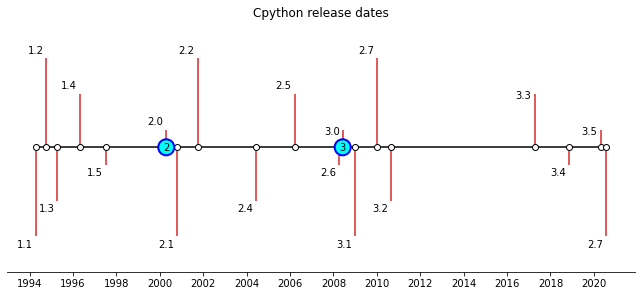

<Figure size 432x288 with 0 Axes>

In [57]:
# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)

# TODO: red lines on minor only
ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="black", markerfacecolor="white")  # Baseline and markers on it.

releases = list(zip(dates, levels, names))
# print(releases[:3])
for (date,level,name) in releases:
        print(date, name)

min_style = dict(textcoords="offset points",
                horizontalalignment="right")
major_style = dict(
        size=10, ha="center", va="center", # rotation=45, 
        bbox=dict(boxstyle="circle,pad=0.3", fc="cyan", ec="b", lw=2)
)

# annotate minor releases
for a_date, a_level, name in releases:
        print(a_date, name)
        # if is_minor(name):
        #         label = name[:-2]  # "major.minor"
        # else:
        #         continue
        label = name
        vert="bottom" if a_level > 0 else "top"
        if label.startswith('3'):
                vert = "top"
        ax.annotate(label, xy=(a_date, a_level),
                xytext=(-3, np.sign(a_level)*3),
                verticalalignment=vert,
                **min_style)

# major releases get big blue circle
major_pat = re.compile(r'([0-9]+)\.0')
for a_date, a_level, name in releases:
        match = major_pat.match(name)
        if not match:
                continue
        label = match.group(1)  # "major" (no minor nor micro)
        ax.text(a_date, 0, label, **major_style)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set(title=f"{project_name.title()} release dates")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.2)

plt.show()

plt.savefig(f"{project_name}-releases.png")